# Model Implementation

## Initialize Packages

In [15]:
import sys
import pandas as pd
import numpy as np
import os
import rich
import xgboost as xgb
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_tweedie_deviance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from scipy.stats import uniform, randint

In [16]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

## Load Data and Assign Predictors

In [17]:
model_data = pd.read_csv('../backend/model_data.csv')
final_model_data = pd.read_csv('../backend/train_df_final.csv')
final_model_val_data = pd.read_csv('../backend/val_df_final.csv')

In [18]:
final_model_data['claim_cst_per_exposure'] = final_model_data['claimcst0'] / final_model_data['exposure']
final_model_data.head(5)

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,1,73.0,646.516469,0.0,0.0,1.0,1.0,2.0,0.0,0.0,161,2.0,2,7.0,5.80,2023.198184,1,1,0.362191,5585.998969
1,2,88.0,635.400369,0.0,1.0,2.0,0.0,1.0,0.0,4.0,100,0.0,4,6.0,5.67,3600.172234,1,1,0.632068,5695.859540
2,3,55.0,646.463131,0.0,0.0,2.0,2.0,1.0,0.0,3.0,74,3.0,2,5.0,5.90,2021.144067,1,1,0.367460,5500.307127
3,4,98.0,645.598794,0.0,0.0,3.0,1.0,1.0,1.0,0.0,121,0.0,3,6.0,4.79,4006.845492,1,1,0.802184,4994.920513
4,5,66.0,657.348612,0.0,1.0,2.0,2.0,2.0,1.0,1.0,75,3.0,3,5.0,6.68,2542.953931,1,1,0.485009,5243.106060


In [19]:
final_model_val_data.head()

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure
0,10,74.0,648.136355,0.0,0.0,1.0,1.0,1.0,0.0,1.0,267,0.0,4,8.0,6.49,3906.881054,1,1,0.746884
1,14,59.0,654.686205,0.0,1.0,2.0,3.0,1.0,1.0,1.0,129,1.0,3,5.0,6.56,4260.552605,1,1,0.848036
2,15,62.0,642.842943,0.0,0.0,2.0,2.0,2.0,1.0,3.0,122,3.0,2,5.0,6.09,2056.330796,1,1,0.356544
3,19,83.0,655.733899,0.0,1.0,2.0,1.0,1.0,1.0,1.0,115,3.0,4,5.0,7.13,4756.658716,1,1,0.896206
4,25,63.0,642.523923,0.0,1.0,1.0,0.0,1.0,1.0,3.0,183,3.0,3,7.0,6.37,2347.028119,1,1,0.401096


In [20]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(11204, 25)
(3796, 25)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,suv,2,f,b,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,stnwg,4,f,a,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,sedan,2,f,c,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,stnwg,3,m,b,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,sedan,3,m,c,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


## Frequency-Severity Modeling

In [21]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support

final_preds = [
    'driving_history_score',
    'credit_score',
    'low_education_ind',
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body_grouped',
    'veh_value'
]

# Define features and target
y = final_model_data['claimcst0'].astype(float)
X = final_model_data[final_preds].copy()
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)

In [22]:
# XGBoost DMatrix with offset
dtrain = xgb.DMatrix(
    X,
    label=y,
    base_margin=np.log(exposure)   # log exposure offset
)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',
    'eval_metric': 'tweedie-nloglik@1.5',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
    'nthread': -1,
    'seed': 42,
    'tree_method': 'hist',
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=5000,
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

[0]	train-tweedie-nloglik@1.5:1121.95760+28.99830	test-tweedie-nloglik@1.5:1121.95206+115.99041
[50]	train-tweedie-nloglik@1.5:683.21825+17.53608	test-tweedie-nloglik@1.5:683.72229+70.76404
[100]	train-tweedie-nloglik@1.5:419.05841+10.62523	test-tweedie-nloglik@1.5:421.00439+43.19282
[150]	train-tweedie-nloglik@1.5:261.84998+6.42213	test-tweedie-nloglik@1.5:267.93606+27.26352
[200]	train-tweedie-nloglik@1.5:169.99892+3.88927	test-tweedie-nloglik@1.5:179.25330+18.16917
[250]	train-tweedie-nloglik@1.5:118.17471+2.45623	test-tweedie-nloglik@1.5:129.75534+12.92781
[300]	train-tweedie-nloglik@1.5:90.49430+1.65892	test-tweedie-nloglik@1.5:103.51670+9.87428
[350]	train-tweedie-nloglik@1.5:76.52015+1.28826	test-tweedie-nloglik@1.5:90.48223+8.04261
[400]	train-tweedie-nloglik@1.5:69.48289+1.13413	test-tweedie-nloglik@1.5:84.55730+7.36205
[450]	train-tweedie-nloglik@1.5:65.69995+1.12141	test-tweedie-nloglik@1.5:82.12254+7.18944
[500]	train-tweedie-nloglik@1.5:63.34480+1.08003	test-tweedie-nlogli

In [23]:
# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    # num_boost_round=500
    num_boost_round=best_num_boost_round
 )

In [24]:
train_pred = model.predict(dtrain)
final_model_data["pred"] = train_pred  # total predicted loss
final_model_data["pred_per_exposure"] = final_model_data["pred"] / final_model_data["exposure"]
rescale_factor_2 = final_model_data['claimcst0'].sum() / final_model_data['pred'].sum()
final_model_data['pred_rescale'] = final_model_data['pred'] * rescale_factor_2

# calculate loss ratio (actual / predicted)
final_model_data["loss_ratio"] = final_model_data["claimcst0"] / final_model_data["pred_rescale"]

In [25]:
print(f"Rescale Factor: {rescale_factor_2}")
rich.print(final_model_data[["claimcst0", "exposure", "pred", "pred_per_exposure", "pred_rescale", "loss_ratio"]].head(10))

Rescale Factor: 1.6208192786630207


claimcst0  exposure        pred  pred_per_exposure  pred_rescale  \
0  2023.198184  0.362191  430.619202        1188.928715    697.955933   
1  3600.172234  0.632068  768.484680        1215.825386   1245.574829   
2  2021.144067  0.367460  284.170990         773.338104    460.589844   
3  4006.845492  0.802184  681.814331         849.947520   1105.097900   
4  2542.953931  0.485009  271.064270         558.884964    439.346222   
5  4216.310125  0.945653  708.989258         749.735092   1149.143555   
6  4058.602445  0.853331  577.047729         676.229354    935.290100   
7  3527.855091  0.648295  775.866699        1196.780806   1257.539795   
8  2002.774201  0.383726  236.498627         616.321241    383.321533   
9  2021.467231  0.377110  335.615814         889.966788    543.972595   

   loss_ratio  
0    2.898748  
1    2.890370  
2    4.388165  
3    3.625783  
4    5.788041  
5    3.669089  
6    4.339405  
7    2.805363  
8    5.224789  
9    3.716120

pred_per_exposure
- Business Meaning: Pure premium — expected loss per unit of exposure
- Used For: Risk scoring and segmentation

pred
- Business Meaning: Total predicted loss for each policy term
- Used For: Premium indication, loss-ratio analysis

rescale_factor_2
- Business Meaning: Calibration factor ensuring total predicted loss matches total actual loss
- Used For: Actuarial consistency and portfolio-level calibration

pred_rescale
- Business Meaning: Calibrated expected total loss per policy
- Used For: Final pricing recommendations, underwriting decisions, rate adequacy analysis

Training Data Metrics:
Top Lift: 4.3516
Gini: 0.7519
RMSE: 1702.43
MAE: 693.04
Tweedie Deviance: 86.29


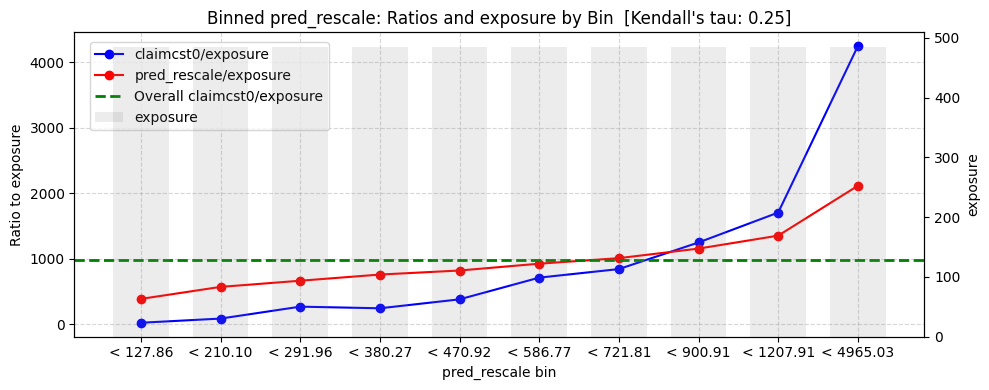

In [26]:
# Select training samples for predictiveness check
data = final_model_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute RMSE, Gini, MAE, and Tweedie Deviance
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()
tweedie_dev = mean_tweedie_deviance(
    y_true=y,
    y_pred=train_pred,
    power=1.5    # same as model.tweedie_variance_power
)

# Print results
print("Training Data Metrics:")
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
# Tweedie Deviance
print(f"Tweedie Deviance: {tweedie_dev:.2f}")


pc.plot(figsize=(10, 4))



1. Top Lift = 4.35
This means:

The top 10% of customers ranked by the model have 4.35× higher average loss than the portfolio overall. That is very strong uplift.

In pricing/underwriting terms: the model sharply concentrates high-risk policies at the top of the predicted distribution.

If used in segmentation, the high-risk group would contain a disproportionate share of actual losses. This is excellent for identifying high-loss segments and building risk tiers.

2. Gini = 0.7519
A Gini of 0.75 is exceptionally high for an insurance severity or pure-premium model.

Interpretation: The model improves risk ranking by 66.8% relative to random — indicating excellent discriminatory power.

This means: The model is extremely good at sorting customers from low to high expected loss. It provides highly actionable ranking for underwriting, risk segmentation, and pricing. Even if absolute predictions are noisy (due to claim rarity), the ordering is outstanding.

3. RMSE = 1702.43 & MAE = 693.04
Interpretation: On average, the prediction misses the true claim cost per exposure by $693.04. Large errors occur due to the heavy tail (RMSE is much larger than MAE).

This is exactly what we might expect: Losses are infrequent but severe when they occur. RMSE is dominated by rare high-cost claims. MAE represents a more realistic “average miss”.

4. Tweedie Deviance = 86.29



In [27]:
# Model metrics on Validation Data
y_val = final_model_val_data['claimcst0'].astype(float)
exposure_val = final_model_val_data['exposure'].astype(float).clip(lower=1e-12)
X_val = final_model_val_data[final_preds].copy()

dval = xgb.DMatrix(
    X_val,
    label=y_val,
    base_margin=np.log(exposure_val)   # log exposure offset
)

val_pred = model.predict(dval)
final_model_val_data["pred"] = val_pred  # total predicted loss
final_model_val_data["pred_per_exposure"] = final_model_val_data["pred"] / final_model_val_data["exposure"]
rescale_factor_2 = final_model_val_data['claimcst0'].sum() / final_model_val_data['pred'].sum()
final_model_val_data['pred_rescale'] = final_model_val_data['pred'] * rescale_factor_2

In [28]:
print(f"Rescale Factor: {rescale_factor_2}")

Rescale Factor: 1.6728530290423447


Validation Data Metrics:
Top Lift: 1.8526
Gini: 0.4938
RMSE: 1873.96
MAE: 761.12
Tweedie Deviance: 114.87


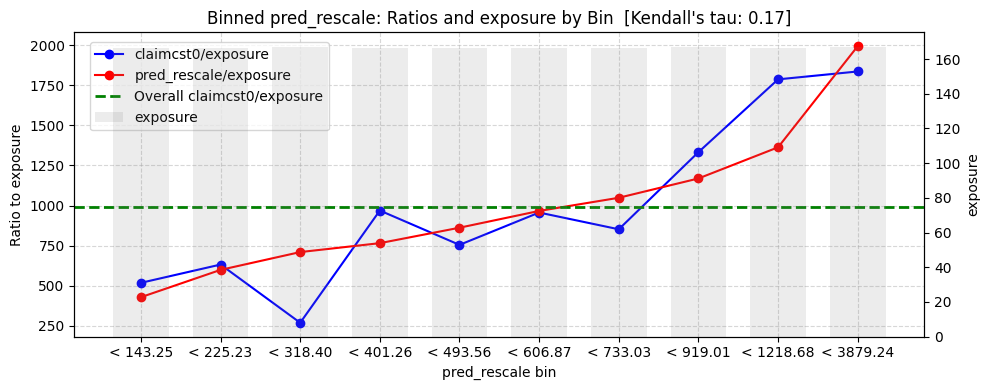

In [29]:
# Select validation samples for predictiveness check
data = final_model_val_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute RMSE, Gini, MAE, and Tweedie Deviance
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()
tweedie_dev = mean_tweedie_deviance(
    y_true=y_val,
    y_pred=val_pred,
    power=1.5    # same as model.tweedie_variance_power
)

# Print results
print("Validation Data Metrics:")
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
# Tweedie Deviance
print(f"Tweedie Deviance: {tweedie_dev:.2f}")

pc.plot(figsize=(10, 4))

A Tweedie deviance of 87.47 indicates that the Tweedie XGBoost model provides a strong fit to the distributional characteristics of auto insurance losses — including the large number of zero-claim policies and the heavy-tailed nature of positive claim amounts.

The model captures both frequency and severity patterns well, the Tweedie distribution is designed to model:
- zero-inflated claim outcomes
- highly skewed positive losses

A deviance of 87.47 suggests the model is able to correctly represent these structural features of the claims data.

In [30]:
# calculate feature importance
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
6,agecat_grouped,1051.800171
3,marital_status,1014.715576
1,credit_score,992.478882
2,low_education_ind,963.014771
11,veh_age,960.589294
0,driving_history_score,958.046326
8,veh_color,930.770569
9,max_power,898.224182
13,veh_value,893.321777
4,time_driven,886.853699


In [31]:
# Predict on inference data
inference_data = pd.read_csv('../backend/inf_df_final.csv')

for col in final_preds:
    inference_data[col] = inference_data[col].astype(float)

X_inference = inference_data[final_preds]

exposure_infer = inference_data['exposure'].astype(float).clip(lower=1e-12)
dinf = xgb.DMatrix(
    X_inference,
    base_margin=np.log(exposure_infer)   # log exposure offset
)

inference_pred = model.predict(dinf)
inference_data["pred"] = inference_pred  # total predicted loss
inference_data["pred_per_exposure"] = inference_data["pred"] / exposure_infer
inference_data['pred_rescale'] = inference_data['pred'] * rescale_factor_2
inference_data['pred_per_exposure_rescale'] = inference_data['pred_rescale'] / exposure_infer

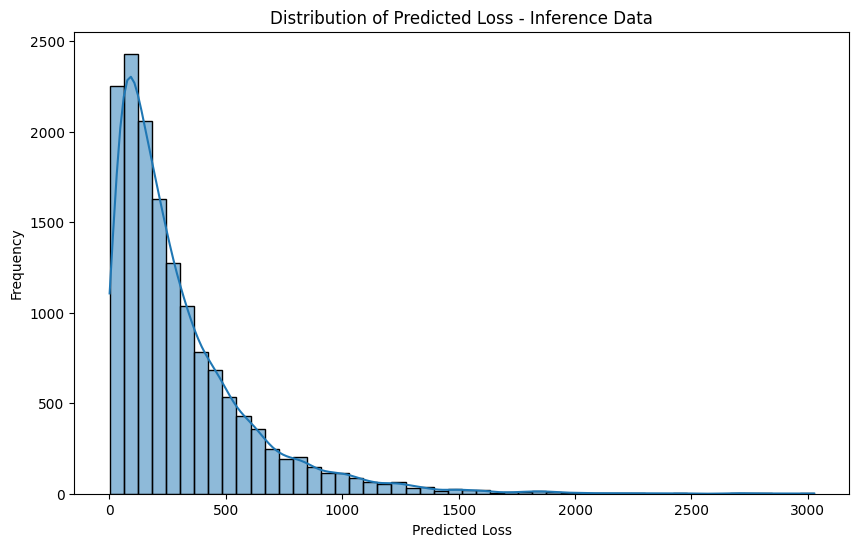

In [32]:
# Plot distribution of predicted loss per exposure for inference data
plt.figure(figsize=(10, 6))
sns.histplot(inference_data['pred'], bins=50, kde=True)
plt.title('Distribution of Predicted Loss - Inference Data')
plt.xlabel('Predicted Loss')
plt.ylabel('Frequency')
plt.show()

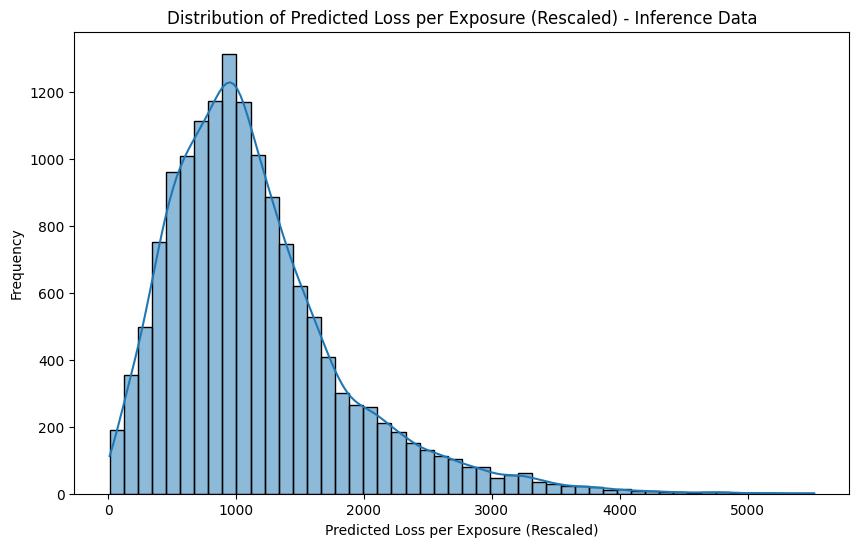

In [33]:
# Plot distribution of predicted loss per exposure rescaled for inference data
plt.figure(figsize=(10, 6))
sns.histplot(inference_data['pred_per_exposure_rescale'], bins=50, kde=True)
plt.title('Distribution of Predicted Loss per Exposure (Rescaled) - Inference Data')
plt.xlabel('Predicted Loss per Exposure (Rescaled)')
plt.ylabel('Frequency')
plt.show()

#### Example Use Case of single user prediction with API

In [34]:
encoded = {
    'driving_history_score': 80,
    'credit_score': 600,
    'low_education_ind': 0,
    'marital_status': 1,
    'time_driven': 1,
    'area': 0,
    'agecat_grouped': 2,
    'gender': 1,
    'veh_color': 6,
    'max_power': 128,
    'engine_type': 3,
    'veh_age': 3,
    'veh_body_grouped': 4,
    'veh_value': 6.5
}
exposure = 0.45
exposure_vec = np.array([exposure], dtype=np.float32)
df = pd.DataFrame([encoded])

dnew = xgb.DMatrix(
    df,
    base_margin=np.log(exposure_vec)
)
pred = model.predict(dnew)[0]

print("Prediction:", pred)

Prediction: 602.47565


### Shapley Additive Explanations for Tweedie Model


--- Starting SHAP Analysis for Tweedie Model ---
Successfully created TreeExplainer.
Calculating SHAP values... (This may take a few minutes)
SHAP calculations complete.


/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3077848431.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


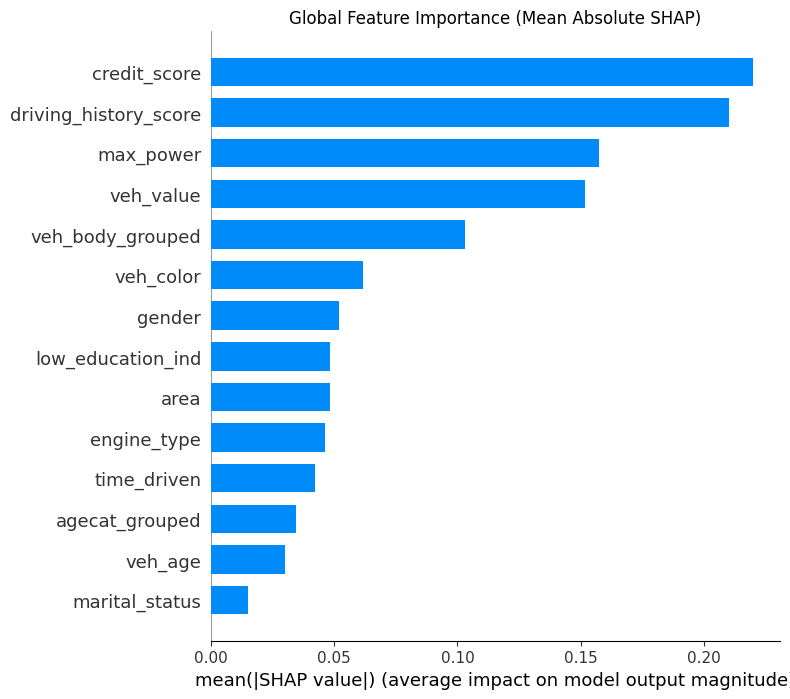

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3077848431.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


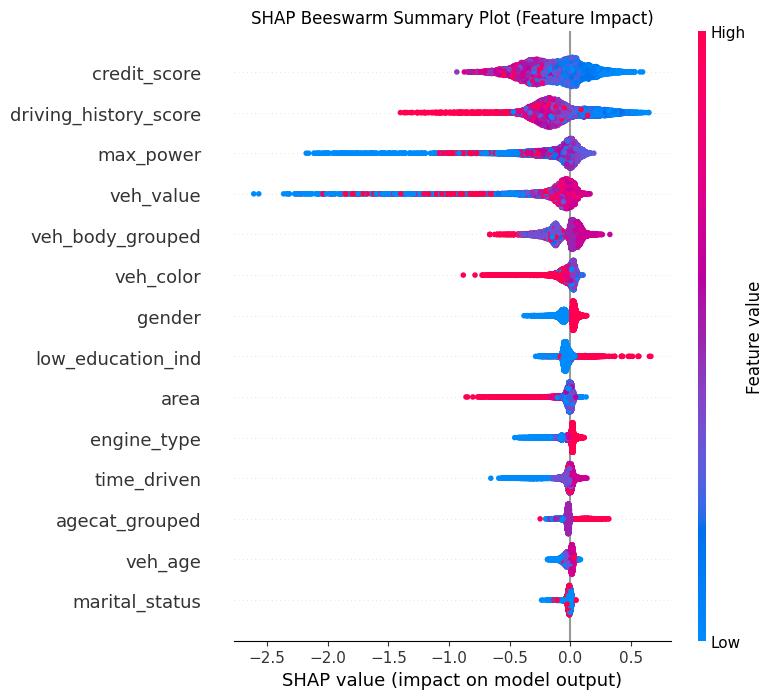

In [35]:
predictor_data = final_model_data[final_preds]

print("\n--- Starting SHAP Analysis for Tweedie Model ---")

# --- 2. Create the SHAP Explainer ---
# We use TreeExplainer for XGBoost, Random Forest, etc. ; shap.KernelExplainer is for other models but is *very* slow.
try:
    explainer = shap.TreeExplainer(model)
    print("Successfully created TreeExplainer.")
except Exception as e:
    print(f"Could not create TreeExplainer ({e}).")
    print("If this is not a tree-based model, use shap.KernelExplainer(model.predict, predictor_data).")


# --- 3. Calculate SHAP Values ---
# This runs the explainer on your entire training set to get a global view
print("Calculating SHAP values... (This may take a few minutes)")
shap_values = explainer(predictor_data)

print("SHAP calculations complete.")

# --- 4. Plot 1: Feature Importance (Bar Chart) ---
# This is the "Executive Summary" plot. It shows the mean absolute SHAP value for each feature.
plt.figure()
plt.title("Global Feature Importance (Mean Absolute SHAP)")
shap.summary_plot(
    shap_values, 
    predictor_data, 
    plot_type="bar",
    show=False
)
plt.show()

# --- 5. Plot 2: Feature Impact (Beeswarm Plot) ---
# This is the "Deep Dive" plot. It shows HOW a feature impacts the model (positively or negatively) and is much more insightful.
plt.figure()
plt.title("SHAP Beeswarm Summary Plot (Feature Impact)")
shap.summary_plot(
    shap_values, 
    predictor_data, 
    plot_type="dot", # 'dot' is also known as 'beeswarm'
    show=False
)
plt.show()

## Risk Segmentation

### Quantiles

In [36]:
final_model_data["risk_quantile"] = pd.qcut(
    final_model_data["pred_per_exposure"],
    q=3,
    labels=["Low", "Medium", "High"]
)

In [37]:
quantiles = final_model_data['pred_per_exposure'].quantile([0.33, 0.66])
q33 = quantiles.iloc[0]
q66 = quantiles.iloc[1]
print(q33, q66)

# save quantiles to a json file
quantile_dict = {
    "q33": q33,
    "q66": q66
}

# Save quantiles to a json file
with open("../backend/models/freq_sev_xgboost/risk_quantiles.json", 'w') as f:
    json.dump(quantile_dict, f)

415.0376327006079 652.9833446167415


### KMeans Clustering

In [38]:
kmeans = KMeans(n_clusters=3, random_state=42)
final_model_data["risk_cluster"] = kmeans.fit_predict(
    final_model_data[["pred_per_exposure"]]
)

cluster_means = final_model_data.groupby("risk_cluster")["pred_per_exposure"].mean()
cluster_order = cluster_means.sort_values().index

mapping = {old:new for new, old in enumerate(cluster_order)}
final_model_data["risk_cluster"] = final_model_data["risk_cluster"].map(mapping)

# Save the k-means model
joblib.dump(kmeans, "models/freq_sev_xgboost/kmeans_clusters.pkl")

['models/freq_sev_xgboost/kmeans_clusters.pkl']

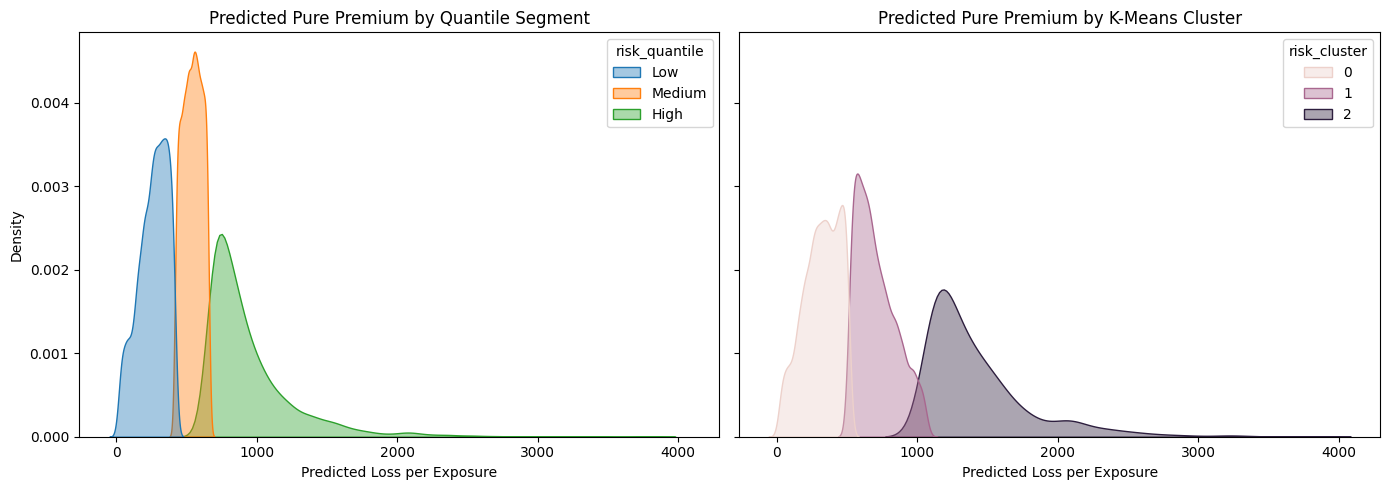

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Left: quantile-based segments
sns.kdeplot(
    data=final_model_data,
    x="pred_per_exposure",
    hue="risk_quantile",
    common_norm=False,
    fill=True,
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_title("Predicted Pure Premium by Quantile Segment")
axes[0].set_xlabel("Predicted Loss per Exposure")
axes[0].set_ylabel("Density")

# Right: k-means clusters
sns.kdeplot(
    data=final_model_data,
    x="pred_per_exposure",
    hue="risk_cluster",
    common_norm=False,
    fill=True,
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("Predicted Pure Premium by K-Means Cluster")
axes[1].set_xlabel("Predicted Loss per Exposure")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [40]:
summary_quant = final_model_data.groupby("risk_quantile").agg(
    avg_pred=("pred_per_exposure", "mean"),
    avg_actual=("claimcst0", lambda x: (x / final_model_data.loc[x.index, "exposure"]).mean()),
    exposure=("exposure", "sum"),
    n=("pred_per_exposure", "size")
).reset_index()

summary_cluster = final_model_data.groupby("risk_cluster").agg(
    avg_pred=("pred_per_exposure", "mean"),
    avg_actual=("claimcst0", lambda x: (x / final_model_data.loc[x.index, "exposure"]).mean()),
    exposure=("exposure", "sum"),
    n=("pred_per_exposure", "size")
).reset_index()

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/438047830.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_quant = final_model_data.groupby("risk_quantile").agg(


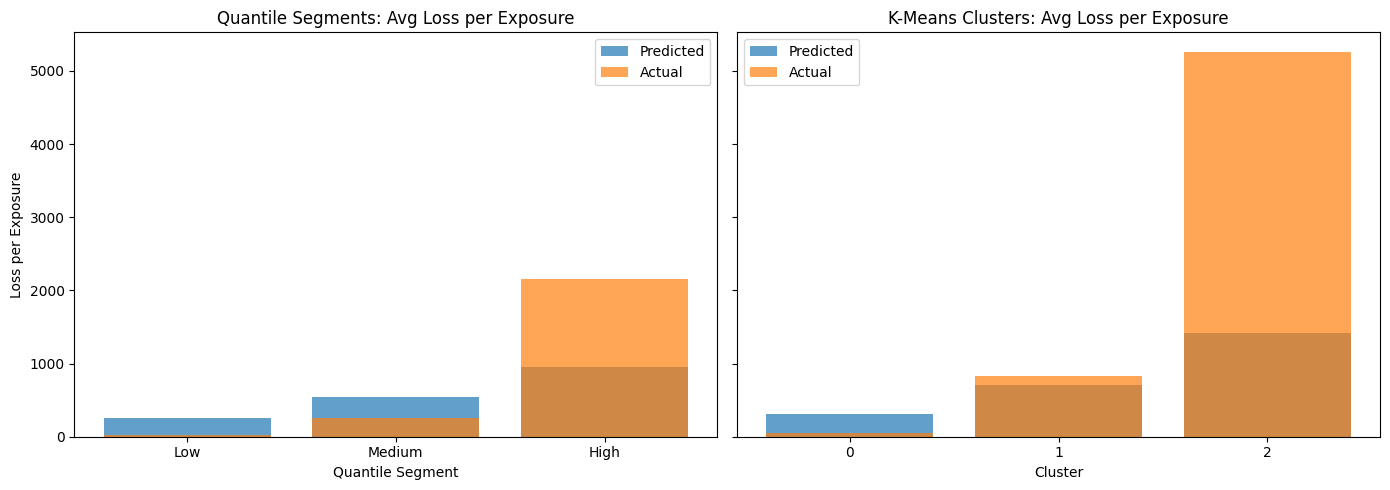

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Quantiles
axes[0].bar(summary_quant["risk_quantile"], summary_quant["avg_pred"], alpha=0.7, label="Predicted")
axes[0].bar(summary_quant["risk_quantile"], summary_quant["avg_actual"], alpha=0.7, label="Actual")
axes[0].set_title("Quantile Segments: Avg Loss per Exposure")
axes[0].set_xlabel("Quantile Segment")
axes[0].set_ylabel("Loss per Exposure")
axes[0].legend()

# K-means
axes[1].bar(summary_cluster["risk_cluster"].astype(str), summary_cluster["avg_pred"], alpha=0.7, label="Predicted")
axes[1].bar(summary_cluster["risk_cluster"].astype(str), summary_cluster["avg_actual"], alpha=0.7, label="Actual")
axes[1].set_title("K-Means Clusters: Avg Loss per Exposure")
axes[1].set_xlabel("Cluster")
axes[1].legend()

plt.tight_layout()
plt.show()

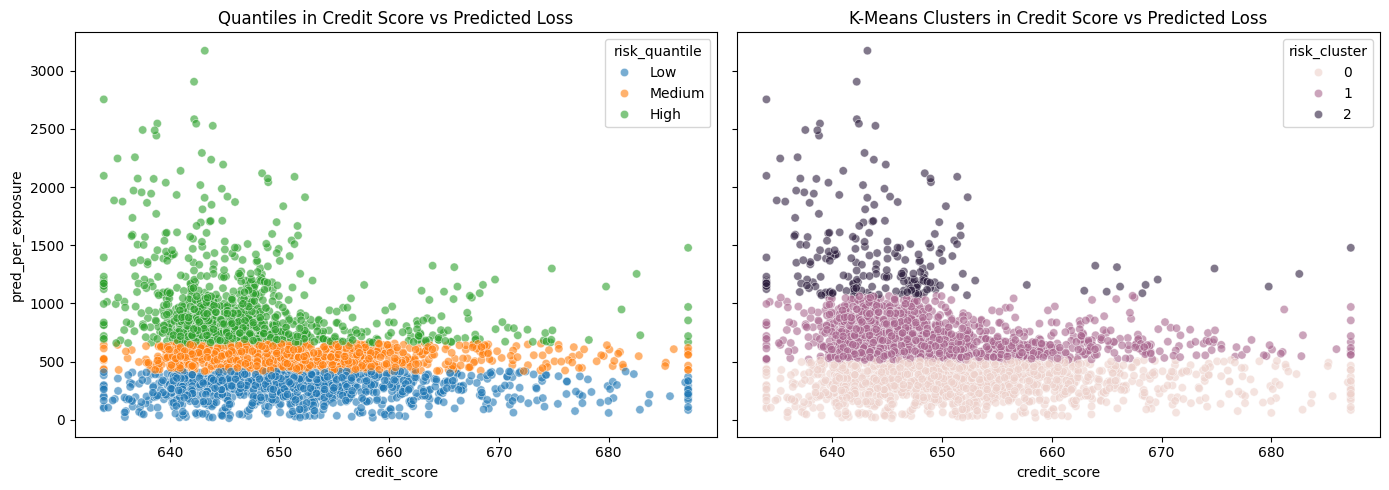

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.scatterplot(
    data=final_model_data.sample(3000, random_state=42),  # sample for clarity
    x="credit_score",
    y="pred_per_exposure",
    hue="risk_quantile",
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title("Quantiles in Credit Score vs Predicted Loss")

sns.scatterplot(
    data=final_model_data.sample(3000, random_state=42),
    x="credit_score",
    y="pred_per_exposure",
    hue="risk_cluster",
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title("K-Means Clusters in Credit Score vs Predicted Loss")

plt.tight_layout()
plt.show()

## Pricing Analysis

In [43]:
def plot_loss_ratio_from_col(df,
                             feature,
                             lr_col='loss_ratio',
                             weight_col=None,
                             n_bins=5,
                             quantile_bins=True,
                             force_categorical=False):
    cols = [feature, lr_col] + ([weight_col] if weight_col else [])
    tmp = df[cols].dropna().copy()

    unique_vals = tmp[feature].nunique()
    is_numeric = pd.api.types.is_numeric_dtype(tmp[feature])

    # decide whether to bin
    if is_numeric and not force_categorical and unique_vals > n_bins:
        # numeric: create bins
        if quantile_bins:
            tmp['bin'] = pd.qcut(tmp[feature], q=n_bins, duplicates='drop')
        else:
            tmp['bin'] = pd.cut(tmp[feature], bins=n_bins)
        group_key = 'bin'
        xlabel = f'{feature} bin'
        title_suffix = 'Bin'
    else:
        # categorical OR forced categorical OR low-card numeric
        group_key = feature
        xlabel = feature
        title_suffix = 'Category'

    # aggregate
    if weight_col is None:
        grouped = tmp.groupby(group_key)[lr_col].mean()
        overall_lr = tmp[lr_col].mean()
    else:
        def w_avg(g):
            return np.average(g[lr_col], weights=g[weight_col])
        grouped = tmp.groupby(group_key).apply(w_avg)
        overall_lr = np.average(tmp[lr_col], weights=tmp[weight_col])

    # plot
    fig, ax = plt.subplots(figsize=(8,4))
    x_labels = list(grouped.index.astype(str))
    y_values = np.array(grouped.values)

    ax.plot(x_labels, y_values, marker='o', label='Avg loss ratio')
    ax.axhline(overall_lr, linestyle='--', label='Overall loss ratio')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Actual / Predicted loss')
    ax.set_title(f'{feature}: Loss Ratio by {title_suffix}')
    ax.legend(loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)
/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


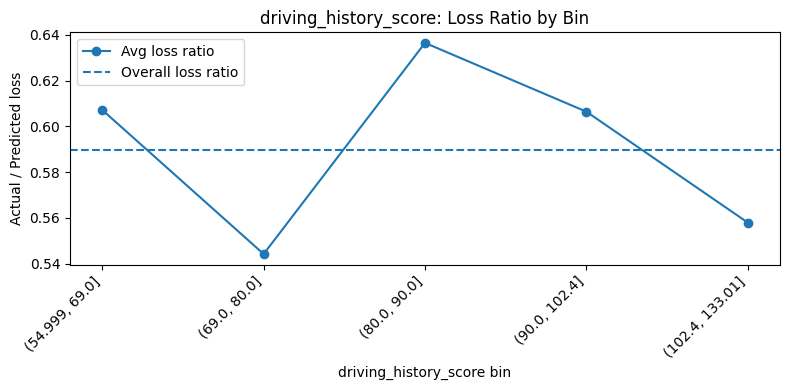

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)
/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


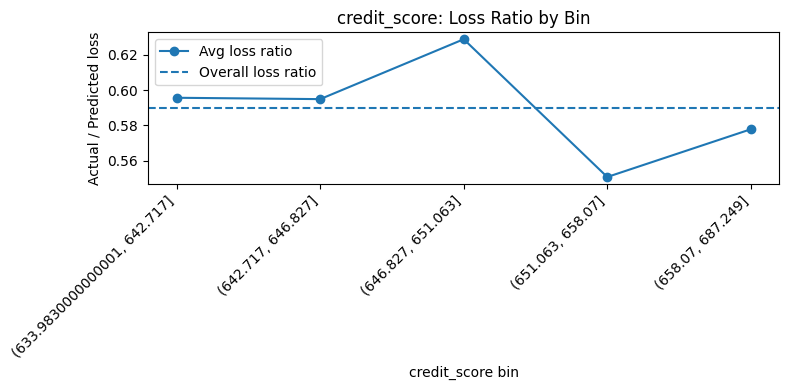

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)
/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


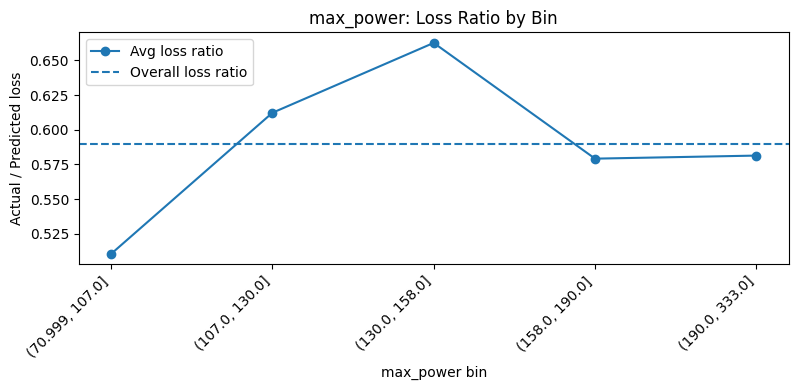

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


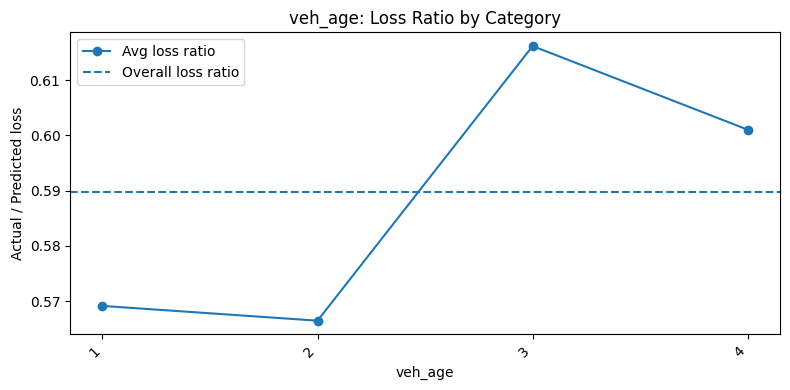

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)
/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


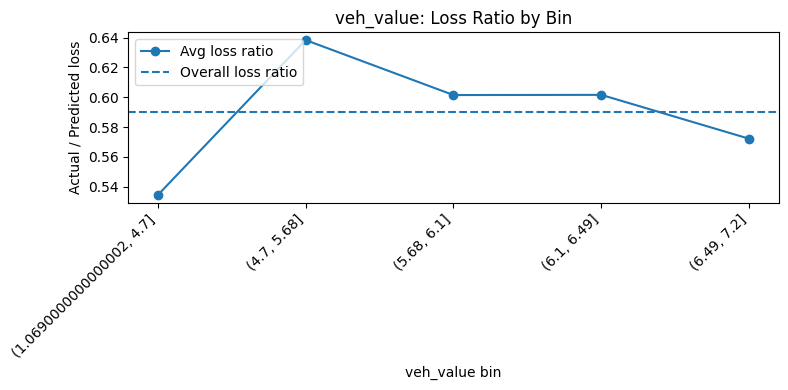

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


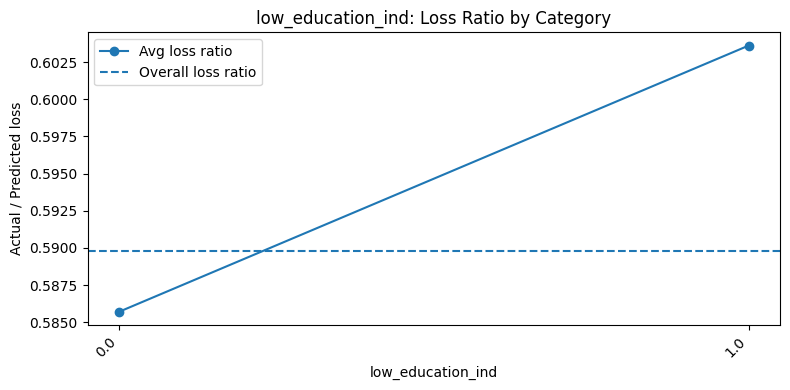

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


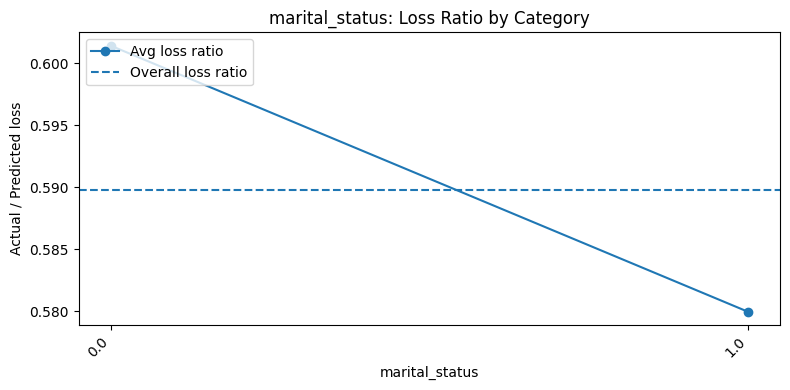

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


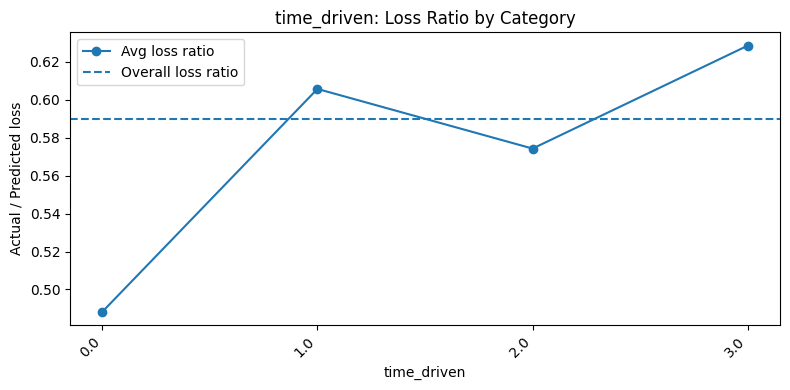

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


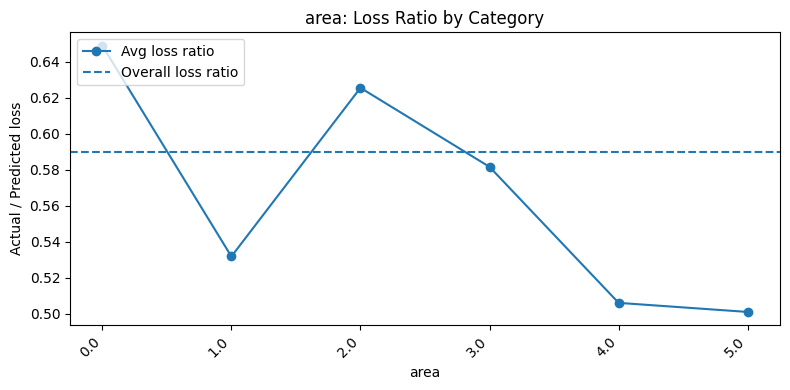

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


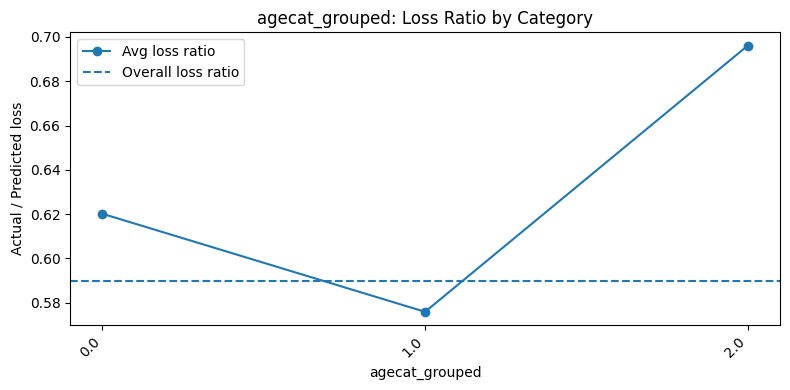

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


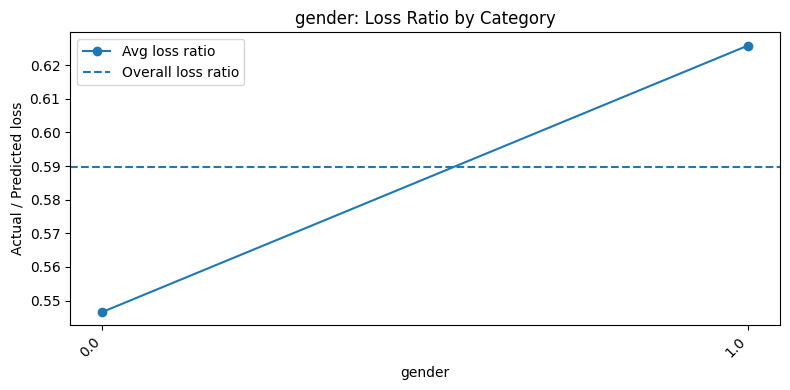

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


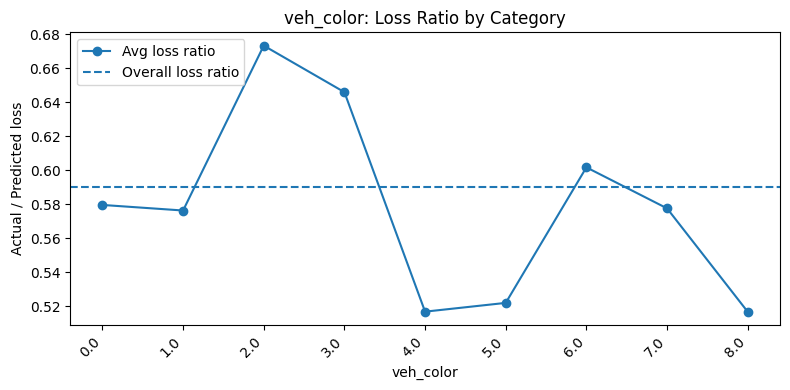

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


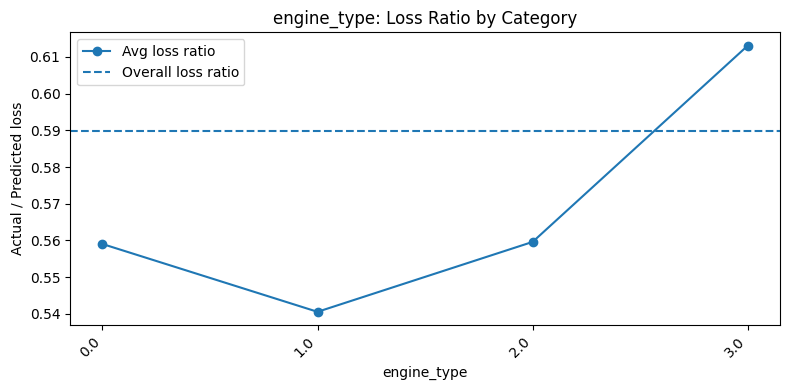

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


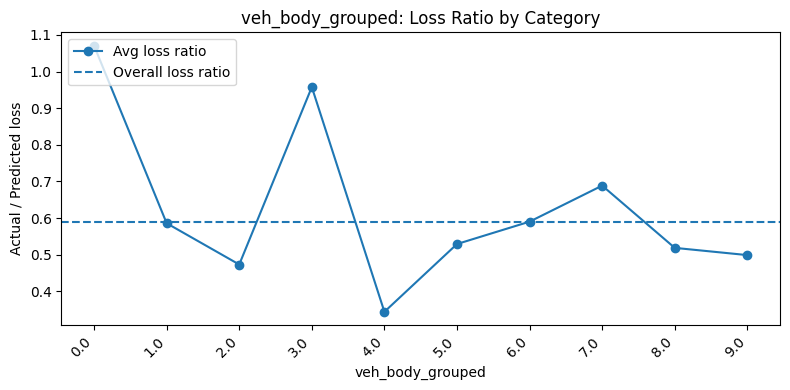

In [44]:
# numeric and categorical predictors
final_preds = [
    'driving_history_score',
    'credit_score',
    'low_education_ind',
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body_grouped',
    'veh_value'
]
categorical_preds = [
    'low_education_ind', 'marital_status', 'time_driven', 'area',
    'agecat_grouped', 'gender', 'veh_color', 'engine_type', 'veh_body_grouped'
]

continuous_preds = [
    'driving_history_score', 'credit_score', 'max_power',
    'veh_age', 'veh_value'
]

for col in continuous_preds:
    plot_loss_ratio_from_col(final_model_data, col,
                         lr_col='loss_ratio', weight_col='exposure')
    
for col in categorical_preds:
    plot_loss_ratio_from_col(final_model_data, col,
                         lr_col='loss_ratio', weight_col='exposure',
                         force_categorical=True)

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)
/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_82634/3485630086.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = tmp.groupby(group_key).apply(w_avg)


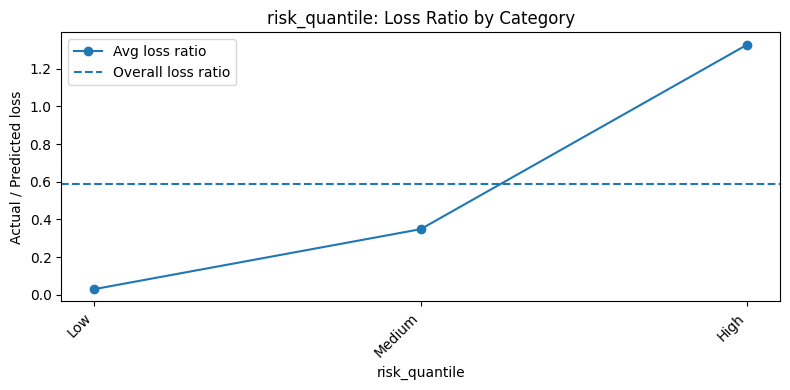

In [45]:
plot_loss_ratio_from_col(final_model_data, 'risk_quantile',
                         lr_col='loss_ratio', weight_col='exposure')

## Export Model Artifacts

In [ ]:
# 1) Save the trained model
#joblib.dump(model, "../backend/models/freq_sev_xgboost/model.pkl")

# 2) Save the exact feature column order used to fit the model
# feature_columns = list(X_val.columns)  # if you trained with a DataFrame
# with open("../backend/models/freq_sev_xgboost/feature_columns.json", "w") as f:
    # json.dump(feature_columns, f)